<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_Reclame_Aqui_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Latent Dirichlet Allocation (LDA) - Reclame Aqui**

LDA is an unsupervised learning algorithm which is able to learns about the structure of the data by analyzing the relationships between words and documents. LDA is based on the idea that each document in a collection can be represented as a mixture of a small number of topics, and that each topic is a distribution over the words in the vocabulary. The model estimates the probability of each word in a document given the topics present in that document, and it also estimates the probability of each topic given the words in the document.

Reference: BLEI, D. M. 2012 Probabilistic topic models. Communications of the ACM, 55(4): pp.77_84.


### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

#### **Load dependecies**

In [3]:
%%capture
import pandas as pd # for data manipulation
import os # for interacting with the operating system
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle
import numpy as np
import itertools
from matplotlib.lines import Line2D
import seaborn as sns
import csv
import ast # for convert str to tuple
try:
  from wordcloud import WordCloud
  import optuna # for hyperparameter optimization
  import pyLDAvis
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_tokenize
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models.phrases import Phrases, Phraser
except:
  !pip install gensim
  !pip install pyldavis
  !pip install optuna
  !pip install wordcloud
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models import LdaMulticore
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_preprocess
  from gensim.models.phrases import Phrases, Phraser
  import optuna # for hyperparameter optimization


#### **Github**

In [2]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:EmmyApPSNHNgS8bgvLi8SfTY2HQFiaYdAmZ8wgRh+5k root@d5fa336db4d5
The key's randomart image is:
+---[RSA 4096]----+
|@OO.o..          |
|*%oX ...         |
|=+X o +.         |
|o+o.o+..         |
|.o.E... S        |
|o.B..  .         |
|.= +             |
|. o              |
| o               |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-9c9abdde


In [4]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDK5c8RaXF2UqTpVNb+bwXh9fmYY3D52SkHgSsVwYZRDLfg1Pw53bshodgswOSnApMX3EIRIaaMRNUhzFf8xmiBV7k1T6pvnJzSXvu1p5RLpLwe9GS/HemyzrWitECDDXYjh5dzp4XJe0pIprKYJL7D2xkeOU1IqBHp/AwfuSKO4Hx51eg2TzphAcRNijKYIY4mrxNRymWe5FaNj9cdzFo0GOsozrNbIoNQA7lZtq4+b0b/zJevapLhgnfjJ0IQWW+5jop8RIjV/OQya5DFYZhkKi4i8hBWZ+yuFr3O+vhfCiwegx1OJ9WNL8+dzz6fNZG8m2runB5gF/qBcfk3XdB6mU0QQh7RLqbQaF5iE5rbvDk0pZkm7vsWG+BYujJ1QZLRXkxXiq5jR+rri6040GpV0B6ungMWlL+u1niKITkeXPjZfwVsU7yNDWjfx8TDrXOJbyC/M8sLXcLuGNYWz71N8rEbFlyp097d+p+A7BU129IctiAoTKSYJe2Bf9KnreclUt1b+5h/6Sbk2q8HZQ67TVHRjt3Ez78bo7oKvRjt7FY08onUqTaKVzAB/G+EuyX9A5E4iiLnV3bhTXKHsWxo8OqTH1ZxTyotm0fuJYPsKt0w3oft+2skTOGngyjHgCEJTWEgVFT8WihNPwsvKB3xJlCBHBVX2hyohSF37iaHSw== root@d5fa336db4d5


In [5]:
!git config --global user.email "mattheus_ribeiro@outlook.com"
!git config --global user.name "punkmic"

In [6]:
!ssh -T git@github.com

git@github.com: Permission denied (publickey).


In [8]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 19434, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (273/273), done.
remote: Total 19434 (delta 171), reused 200 (delta 55), pack-reused 19105
Receiving objects: 100% (19434/19434), 271.62 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (3547/3547), done.
Updating files: 100% (1155/1155), done.


In [9]:
# import custom module
%cd /content/Topic-Modeling-Reclame-Aqui/utils
from max_limit import max_limit
%cd ../

/content/Topic-Modeling-Reclame-Aqui/utils
/content/Topic-Modeling-Reclame-Aqui


In [ ]:
#%cd /content/Topic-Modeling-Reclame-Aqui/

#### **Load dataset**

In [10]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui'
DATASETS_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'

In [11]:
df = pd.read_csv(os.path.join(DATASETS_DIR, f'processed_v1.csv'))

In [12]:
df.head(3)

,title,documents,documents_nouns,bigrams,noun_bigrams,trigrams,noun_trigrams,freq_words_removed,freq_words_removed_nouns
0,pedir cancelado justificativa semana compro,pesquisando bastante novo comprar resolver agu...,semana desconto promoção desconto compra custo...,"[('pesquisando', 'bastante'), ('bastante', 'no...","[('semana', 'desconto'), ('desconto', 'promoçã...","[('pesquisando', 'bastante', 'novo'), ('bastan...","[('semana', 'desconto', 'promoção'), ('descont...",pesquisando bastante novo resolver aguardar se...,semana desconto promoção desconto plataforma c...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...,procon audiência conciliação solicitação produ...,"[('sinceramente', 'decepcionar'), ('decepciona...","[('procon', 'audiência'), ('audiência', 'conci...","[('sinceramente', 'decepcionar', 'entrar'), ('...","[('procon', 'audiência', 'conciliação'), ('aud...",sinceramente decepcionar procon hoje informar ...,procon audiência conciliação solicitação estoq...
2,cobrança indever,cancelei plano antes terminar período testir g...,cancelei período plataforma fatura gratuito ca...,"[('cancelei', 'plano'), ('plano', 'antes'), ('...","[('cancelei', 'período'), ('período', 'platafo...","[('cancelei', 'plano', 'antes'), ('plano', 'an...","[('cancelei', 'período', 'plataforma'), ('perí...",cancelei plano antes terminar período testir g...,cancelei período plataforma fatura gratuito ca...


In [13]:
COLNAME = 'freq_words_removed_nouns'
# remove any na value
df.dropna(subset=[COLNAME], inplace=True)
documents = df[COLNAME]
print(len(documents))
print(documents[:1])

10292
0    semana desconto promoção desconto plataforma c...
Name: freq_words_removed_nouns, dtype: object


In [14]:
LDA_RESULTS_DIR = os.path.join('/content/Topic-Modeling-Reclame-Aqui/lda/', COLNAME)

## **KMeans Model**

#### **K-Means elbow**

The elbow method is a type of method for checking the consistency of clusters created. It  finds the ideal number of clusters in data. Explained variance considers the percentage of variance explained and derives an ideal number of clusters. 

In [15]:
if not os.path.exists(LDA_RESULTS_DIR):
    os.makedirs(LDA_RESULTS_DIR)

In [16]:
# convert text documents to bag of words representation
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(documents)

In [19]:
def plot_elbow(n_clusters= 20):
  elbow_method = {}
  for k in range(1, n_clusters):
    kmeans_elbow = KMeans(n_clusters=k, random_state=22).fit(x)
    elbow_method[k] = kmeans_elbow.inertia_

  # plot elbow
  plt.figure(figsize=[8, 8])
  plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
  plt.title('Elbow', fontsize=16)
  plt.xlabel('Número de grupos (clusters)')
  plt.ylabel('Soma de quadrados dentro do cluster')

  # save plot
  plt.savefig(os.path.join(LDA_RESULTS_DIR, f'elbow_{n_clusters}_{COLNAME}.png'))

  # show the plot
  plt.show()

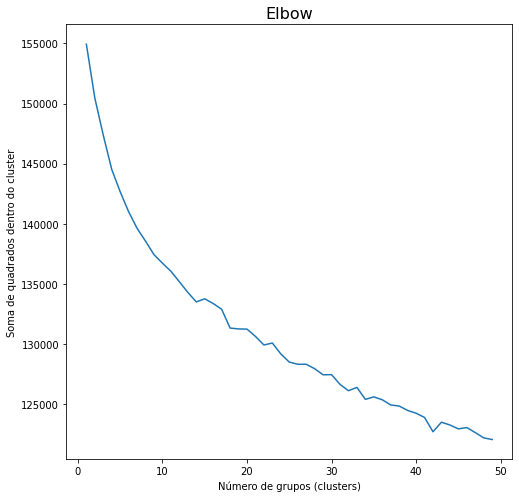

CPU times: user 4min 19s, sys: 1.02 s, total: 4min 20s
Wall time: 3min 6s


In [20]:
%%time
plot_elbow(50)

#### **Silhouette**

The silhouette coefficient, or silhouette score, tells how much the object is similar to  other clusters compared to its own cluster. The value varies from –1 to 1, where a high  value indicates that the cluster fits well with itself, and the cluster does not match the neighboring cluster. 

A score towards -1 indicates bad clustering, a score towards 0 indicates mixed-quality clustering, and a score towards 1 indicates optimal clustering.

In [21]:
clusters = []
scores = []
for n_cluster in range(2, 15):
  kmeans = KMeans(n_clusters=n_cluster, random_state=22).fit(x)
  label = kmeans.labels_
  sil_coeff = silhouette_score(x, label, metric='euclidean')
  print(f"Number of clusters={n_cluster}, Silhouette Coefficient is {sil_coeff}")
  clusters.append(n_cluster) 
  scores.append(sil_coeff)

Number of clusters=2, Silhouette Coefficient is 0.2767462825030314
Number of clusters=3, Silhouette Coefficient is 0.21711401629764607
Number of clusters=4, Silhouette Coefficient is 0.20095457739934247
Number of clusters=5, Silhouette Coefficient is 0.1606125336663262
Number of clusters=6, Silhouette Coefficient is 0.08542427148871609
Number of clusters=7, Silhouette Coefficient is 0.06622254354176318
Number of clusters=8, Silhouette Coefficient is 0.05287691012503424
Number of clusters=9, Silhouette Coefficient is 0.051354860384543725
Number of clusters=10, Silhouette Coefficient is 0.04315451067284093
Number of clusters=11, Silhouette Coefficient is 0.03667356364595691
Number of clusters=12, Silhouette Coefficient is 0.04381610433784864
Number of clusters=13, Silhouette Coefficient is 0.03442424390749335
Number of clusters=14, Silhouette Coefficient is 0.03995430240472378


In [22]:
df_silh = pd.DataFrame({'cluster':clusters,'score': scores})
df_silh.to_csv(os.path.join(LDA_RESULTS_DIR, f'silhouette_scores.csv'), index=False)

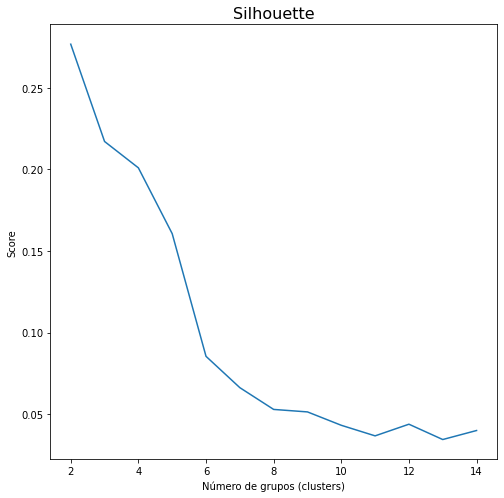

In [23]:
# plot elbow
plt.figure(figsize=[8, 8])
plt.plot(clusters, scores)
plt.title('Silhouette', fontsize=16)
plt.xlabel('Número de grupos (clusters)')
plt.ylabel('Score')

# save plot
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'silhouette_{COLNAME}.png'))

# show the plot
plt.show()

#### **Clustering model**

In [24]:
# create a model with two clusters and train it
segments = KMeans(n_clusters=2, random_state=22)
segments.fit(x)

# get model labels
output = segments.labels_.tolist()
output_df = pd.DataFrame({'texts': documents, 'cluster': output})

output_df['cluster'] = segments.labels_.tolist()

cluster_1 = output_df[output_df.cluster == 1]
cluster_0 = output_df[output_df.cluster == 0]

**Wordcloud of cluster 1**

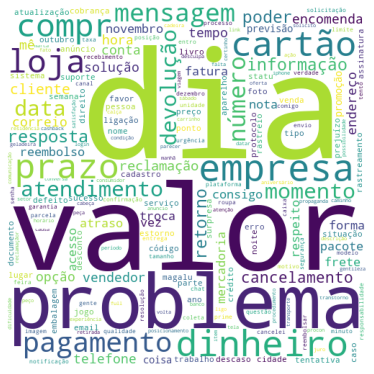

In [270]:
wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False, 
                      colormap='viridis', 
                      background_color ='white', 
                      random_state=20).generate_from_text(' '.join(cluster_1['texts']))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'cluster_1_wordcloud.png'))
plt.show()

**Wordcloud of cluster 0**

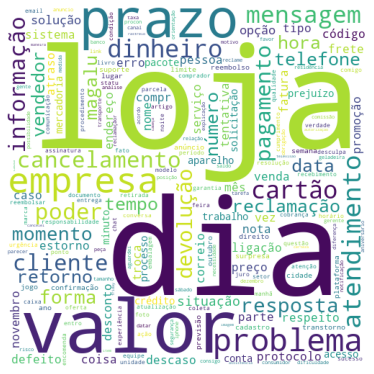

In [26]:
wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False,
                      background_color ='white', 
                      colormap='viridis',
                      random_state=20).generate_from_text(' '.join(cluster_0['texts']))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'cluster_0_wordcloud.png'))
plt.show()

## **LDA models**

#### **Plot coherence**

Coherence score measures how semantically close the words in a topic are to each other. Higher coherence scores indicate that the words in a topic are more semantically similar, and therefore the topic is more interpretable and meaningful.

In [113]:
optimum_topics = []
def plot_coherence(coherence_scores, n_topics, prefix):
  # create the plot
  plt.figure(figsize=[10, 8])

  # create a line plot
  ax = sns.lineplot(x=list(coherence_scores.keys()), y=list(coherence_scores.values()), color='#238C8C')

  # add labels to the axes
  plt.xlabel('Número de Tópicos')
  plt.ylabel('Coerência (score)')
  plt.title("Coerência vs número de tópicos", fontsize=18)
  
  # set x-axis limits
  plt.xlim(2, n_topics)

  # customize x-ticks
  plt.xticks(range(2, n_topics, 2))

  # Add a vertical line to show the optimum number of topics
  position = list(coherence_scores.keys())[np.argmax(list(coherence_scores.values()))]
  optimum_topics.append(position)
  plt.axvline(position,  color='#F26457', linestyle='--')  

  # Draw a custom legend
  legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Valor de coerência (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Número de tópicos ótimo')]

  ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

  ax.tick_params(axis='x', labelsize=14)
  ax.tick_params(axis='y', labelsize=14)

  # save plot
  plt.savefig(os.path.join(LDA_RESULTS_DIR, f'{prefix}_coherence_by_topics.png'))

  # show the plot
  plt.show()

In [224]:
NUMBER_OF_TOPICS = 30
coherences = {}

#### **Unigram LDA**

In [225]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Tokenize the text data
texts = [
      [word for word in document.lower().split()]
      for document in documents
]

# Create a dictionary from the tokens
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.80)

# Create a corpus from the tokens
corpus = [dictionary.doc2bow(token) for token in texts]

# Create a dict to store the coherence scores
coherence_scores = {}

# Create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=4,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()
    coherences['unigram'] = coherence_scores

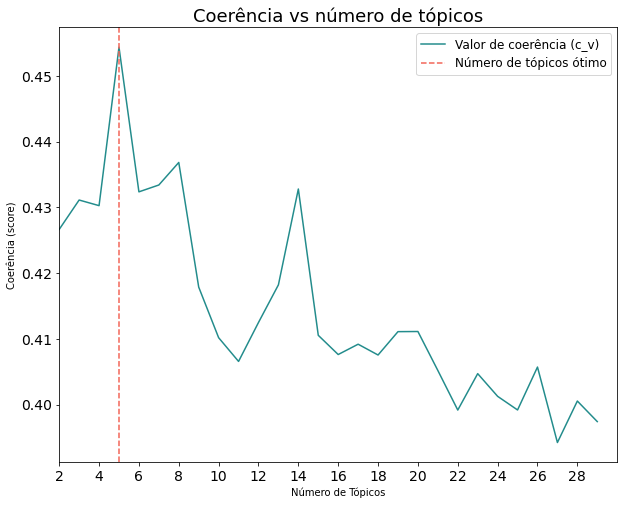

In [226]:
plot_coherence(coherences['unigram'], NUMBER_OF_TOPICS, 'unigrams')

#### **Bigrams LDA**

In [122]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Tokenize the text data
texts = [
      [word for word in document.lower().split()]
      for document in documents
]

# create bigrams
bigram = Phrases(texts)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in texts]

# create a dictionary from the bigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.80)

# create a corpus from the bigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create a dict to store the coherence scores
coherence_scores = {}

# create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=4,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()
    coherences['bigram'] = coherence_scores

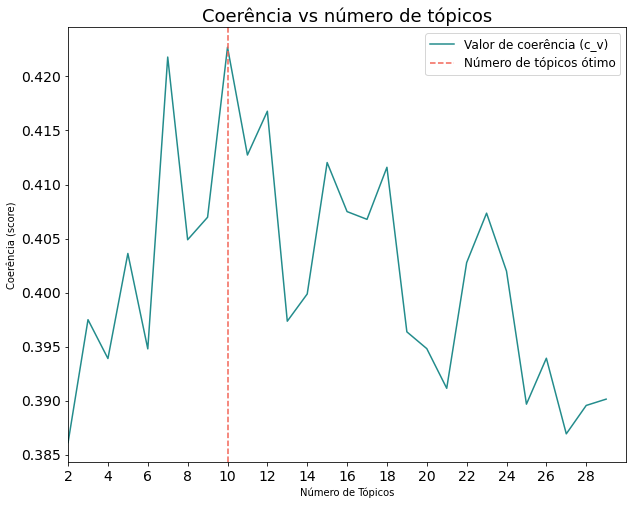

In [123]:
plot_coherence(coherences['bigram'], NUMBER_OF_TOPICS, 'bigrams')

#### **Trigrams LDA**

In [124]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# tokenize the text data
texts = [
      [word for word in document.lower().split()]
      for document in documents
]

# Create trigrams
trigram = Phrases(texts)
trigram_phraser = Phraser(trigram)
texts = [trigram_phraser[bigram_phraser[token]] for token in texts]

# create a dictionary from the trigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.80)

# create a corpus from the trigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create a dict to store the coherence scores
coherence_scores = {}

# create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=4,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()
    coherences['trigram'] = coherence_scores

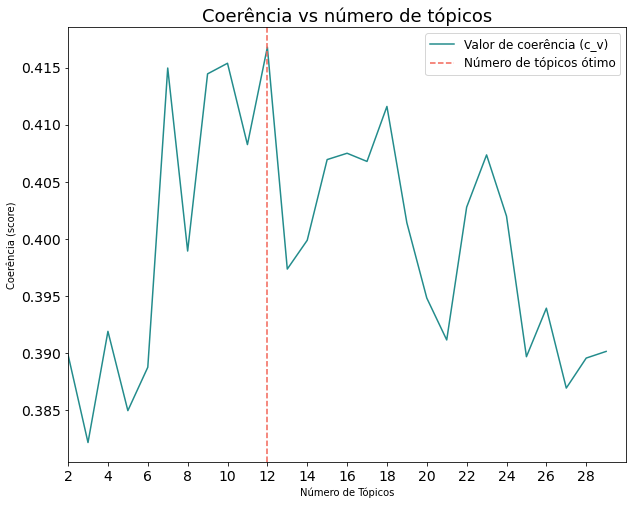

In [125]:
plot_coherence(coherences['trigram'], NUMBER_OF_TOPICS, 'trigrams')

#### **Hyperparameter tuning**

In [236]:
# set the minimum and maximum number of topics based on coherence score plots
MIN_TOPICS = min(optimum_topics) 
MAX_TOPICS = max(optimum_topics) 
def optimizer(trial):
  ngram_range = ast.literal_eval(trial.suggest_categorical('ngram_range', ['(1,1)', '(1,2)', '(1,3)']))
  alpha = trial.suggest_float('lda_alpha', 0.01, 1.0)
  eta = trial.suggest_float('lda__eta', 0.01, 1.0)
  nr_topics = trial.suggest_int('lda__nr_topics', MIN_TOPICS, MAX_TOPICS)
  min_count = trial.suggest_int('bigram__min_count', 2, 20)
  filter = trial.suggest_float('dictionary__filter_extremes', 0.70, 0.95)

  texts = [
      [word for word in document.lower().split()]
      for document in documents
  ]

  if ngram_range == (1,2):
    # Create bigrams
    bigram = Phrases(texts, min_count=min_count)
    bigram_phraser = Phraser(bigram)
    texts = [bigram_phraser[token] for token in texts] 
  elif ngram_range == (1,3):
    # Create bigrams
    bigram = Phrases(texts, min_count=min_count)
    bigram_phraser = Phraser(bigram)
    texts = [bigram_phraser[token] for token in texts] 
    
    # Create trigrams
    trigram = Phrases(texts, min_count=min_count)
    trigram_phraser = Phraser(trigram)
    texts = [trigram_phraser[bigram_phraser[token]] for token in texts]
  
  # create a corpus from a list of texts
  dictionary = Dictionary(texts)

  # Filter out words that occur more than X% of the documents.
  dictionary.filter_extremes(no_above=filter)

  # convert documents to bag of words
  corpus = [dictionary.doc2bow(text) for text in texts]

  # create a new LDA model
  lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=4,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)
  
  # compute coherence score
  score = CoherenceModel(lda_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence()

  new_file = False
  # write header if document does not exists
  if not os.path.exists(os.path.join(LDA_RESULTS_DIR, f'coherence_scores.csv')):
       new_file = True

   # save scores
  if not os.path.exists(LDA_RESULTS_DIR):
     os.makedirs(LDA_RESULTS_DIR)

  with open(path, 'a', newline='') as f:
     fieldnames = ['topic', 'ngram_range', 'alpha', 'eta', 'min_count', 'filter', 'score']
     writer = csv.DictWriter(f, fieldnames=fieldnames)
     data = [{
              'topic': nr_topics, 
              'ngram_range': ngram_range,
              'alpha': alpha,
              'eta': eta,
              'min_count': min_count,
              'filter':filter,
              'score': score
              }]
     if new_file:
       writer.writeheader()
    
     # write rows
     writer.writerows(data)
  return  score

In [237]:
%%time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# delete csv if it exists
path = os.path.join(LDA_RESULTS_DIR, f'coherence_scores.csv')
if os.path.exists(path):
  os.remove(path)

NUMBER_OF_MODELS = 20

# create a new study
study = optuna.create_study(study_name=f'LDA_{COLNAME}', direction='maximize')

# run the optmize function 
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS, show_progress_bar=True)

# best
print(f'Best value:  {study.best_value}')
print(f'Best params: {study.best_params}')

/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-03 02:29:40,364] Trial 0 finished with value: 0.47197153642899325 and parameters: {'ngram_range': '(1,1)', 'lda_alpha': 0.012415425271453647, 'lda__eta': 0.29863740358502044, 'lda__nr_topics': 11, 'bigram__min_count': 5, 'dictionary__filter_extremes': 0.7009248426326764}. Best is trial 0 with value: 0.47197153642899325.
[I 2023-02-03 02:30:11,532] Trial 1 finished with value: 0.4666698608945251 and parameters: {'ngram_range': '(1,1)', 'lda_alpha': 0.4766205430797445, 'lda__eta': 0.11215996702917362, 'lda__nr_topics': 10, 'bigram__min_count': 16, 'dictionary__filter_extremes': 0.7598800128687531}. Best is trial 0 with value: 0.47197153642899325.
[I 2023-02-03 02:30:46,765] Trial 2 finished with value: 0.44742934613584845 and parameters: {'ngram_range': '(1,3)', 'lda_alpha': 0.31720910985801715, 'lda__eta': 0.18347813204812827, 'lda__nr_topics': 6, 'bigram__min_count': 11, 'dictionary__filter_extremes': 0.9327912546852695}. Best is trial 0 with value: 0.47197153642899325.
[I 2

#### **Visualization of Topics**

In [238]:
def save_lda_vis(prefix, lda, nr_topics, corpus, dictionary):
  path = os.path.join(LDA_RESULTS_DIR, f'ldavis_{str(nr_topics)}')

  vis = gs.prepare(lda, corpus, dictionary)
 
  # with open(path, 'wb') as f:
  #       pickle.dump(vis, f)

  # with open(path, 'rb') as f:
  #   vis = pickle.load(f)
  
  pyLDAvis.save_html(vis, os.path.join(LDA_RESULTS_DIR, f'{prefix}_ldavis_{str(nr_topics)}.html'))

In [71]:
def get_topics(lda, nr_topics):
  x=lda.show_topics(num_topics=nr_topics, num_words=10, formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  return pd.DataFrame({'Tópicos': topics, 'Words': words})

In [72]:
def get_words_by_topic_id(lda, topic_id, topn=20):
  return [dictionary[word_id] for word_id, prob in lda.get_topic_terms(topic_id, topn=topn)]

In [73]:
def get_words_n_score_by_topic_id(lda, topics, topn=10):
  ls = []
  for id in topics:
    ls.append([(dictionary[word_id], prob) for word_id, prob in lda.get_topic_terms(id, topn=topn)])
  return ls

#### **Topics of the optimized model**

In [251]:
filename = os.path.join(LDA_RESULTS_DIR, f'coherence_scores.csv')
df_opt = pd.read_csv(filename)

# init variables
max_value = df_opt['score'].max()
row = df_opt.loc[df_opt['score'] == max_value]
alpha = row['alpha'].astype(float).values[0]
eta = row['eta'].astype(float).values[0]
nr_topics = row['topic'].astype(int).values[0]
min_count = row['min_count'].astype(int).values[0]
ngram_range = row['ngram_range'].values[0]
filter_extremes = row['filter'].astype(float).values[0]

# tokenize the text data
texts = [
      [word for word in document.lower().split()]
      for document in documents
]


if ngram_range == (1,2):
    # Create bigrams
    bigram = Phrases(texts, min_count=min_count)
    bigram_phraser = Phraser(bigram)
    texts = [bigram_phraser[token] for token in texts] 
elif ngram_range == (1,3):
    # Create bigrams
    bigram = Phrases(texts, min_count=min_count)
    bigram_phraser = Phraser(bigram)
    texts = [bigram_phraser[token] for token in texts] 
    
    # Create trigrams
    trigram = Phrases(texts, min_count=min_count)
    trigram_phraser = Phraser(trigram)
    texts = [trigram_phraser[bigram_phraser[token]] for token in texts]
  
# create a corpus from a list of texts
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=filter_extremes)

# convert documents to bag of words
corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=4,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)

# save topics terms
topics_terms = get_topics(lda_model, nr_topics)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, 'topics_terms_optimized_model.csv'), index=False)
topics_terms.head(nr_topics)

,Tópicos,Words
0,0,"[prazo, resposta, reclamação, problema, dia, m..."
1,1,"[devolução, dia, troca, pacote, retorno, mensa..."
2,2,"[valor, problema, frete, mês, mercadoria, clie..."
3,3,"[data, atraso, mensagem, prazo, previsão, aten..."
4,4,"[empresa, informação, novembro, nota, telefone..."
5,5,"[pagamento, valor, promoção, correio, desconto..."
6,6,"[loja, atendimento, compr, dia, informação, en..."
7,7,"[dinheiro, dia, cancelamento, momento, cidade,..."
8,8,"[cartão, cancelamento, valor, fatura, cashback..."


In [252]:
print(CoherenceModel(lda_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence())

0.4747610711436006


In [253]:
save_lda_vis('optimized', lda_model, nr_topics, corpus, dictionary)

vis = gs.prepare(lda_model, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


The intertopic distance map is a graphical representation of topics in a two-dimensional way. Different sized circles are used to show different topics and the area of these circles is proportional to the number of words related to these topics in a dictionary. Multidimensional scaling algorithm is used to plot the circles in relation to the words they contain, so topics that are close to each other have a large amount of shared terms.

The bar chart displayed by default contains the 30 most salient terms from the corpus. Salient is a metric used to determine which words are the most useful for identifying topics in the entire set of texts. The bars on the chart signify the total frequency of each term across the corpus, with darker bars indicating a greater frequency of the term specifically belonging to the selected topic. If the darker bar entirely covers the light-colored bar, it indicates that the term almost exclusively belongs to the selected topic.

Lambda is a parameter used to determine the relevance of words in a given topic. When you adjust lambda to a lower number, such as 0, you are more likely to find words that are exclusive to the selected topic, but these words may be rare. If you adjust lambda to a higher number closer to 1, the words you find will be more frequent, but they may not necessarily belong exclusively to the selected topic.

Salience is a measure used to identify which words are the most important for determining the topics in all the documents. The higher the saliency value, the more useful the word is for identifying a specific topic. A saliency value cannot be negative and there is no maximum value it can have. If a word has a saliency value of 0, this means it is equally related to all topics. Saliency looks at words in terms of the entire corpus (all the texts combined) rather than focusing on one particular topic.

Relevance is a measure used to determine the importance of words within a topic. It helps identify which words are the most important for that particular topic and how much they are related to that topic as opposed to other topics. Relevance also considers a parameter called lambda that takes into account how likely it is for a certain term to be part of a topic compared to its lift.

Reference: https://aclanthology.org/W14-3110.pdf

#### **Plot topics terms**

In [260]:
def plot_topics_terms(lda, filename, start = 0, nr_topics= 3):

  topics = range(start, max_limit(lda.num_topics, nr_topics), 1)

  data = get_words_n_score_by_topic_id(lda, topics, topn=10)

  if len(topics) >= 4:
    figheight = 10
    figwidth = 12
    fontsize = 20
    labelsize = 16
  else:
    figheight = 3
    figwidth = 7
    fontsize = 12
    labelsize = 10


  n_rows = int(np.ceil(len(topics) / 3))
  n_cols = min(len(topics), 2)

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(figwidth, figheight), tight_layout=True)
  axs = axs.flatten()

  for i, ax in enumerate(axs):
      if i >= len(topics):
          break
      terms = [d[0] for d in data[i]]
      scores = [d[1] for d in data[i]]
      sns.barplot(x=scores, y=terms, orient="h", ax=ax)
      ax.set_title("Tópico {}".format(topics[i]), fontsize = fontsize)
      ax.tick_params(axis='x', labelsize=labelsize)
      ax.tick_params(axis='y', labelsize=labelsize)

  plt.savefig(os.path.join(LDA_RESULTS_DIR, filename))
  plt.show()



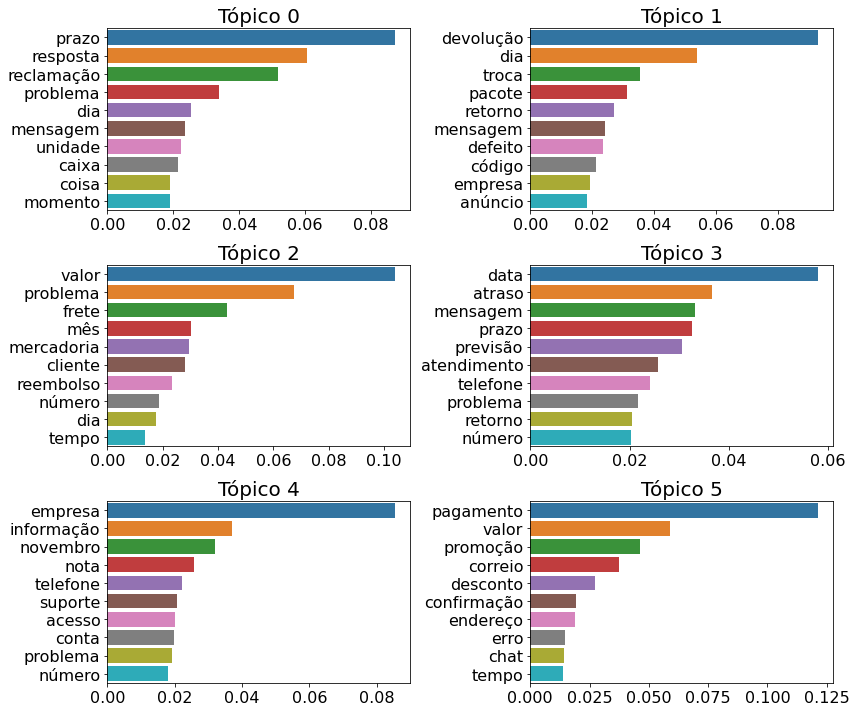

In [254]:
plot_topics_terms(lda_model, 'optimized_model_topics_terms_plot.png', 0, 9)

#### **Wordclouds of optimized model**

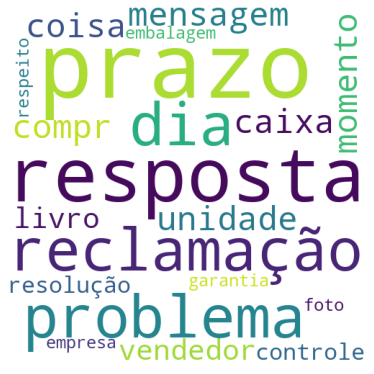

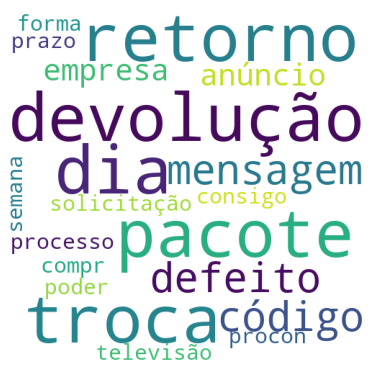

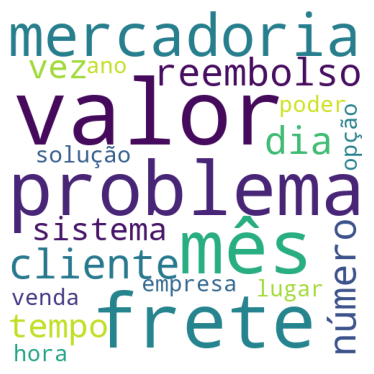

In [257]:
for t in range(max_limit(lda_model.num_topics, 3)):
  wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False,
                      background_color ='white', 
                      colormap='viridis',
                      random_state=20).generate_from_text(' '.join(get_words_by_topic_id(lda_model, t)))
  plt.figure(figsize=(5,5), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  dir = os.path.join(LDA_RESULTS_DIR, 'optimized_model_wordcloud')
  if not os.path.exists(dir):
    os.makedirs(dir)
  plt.savefig(os.path.join(LDA_RESULTS_DIR, 'optimized_model_wordcloud', f'optimization_wordcloud_topic_{str(t)}.png'))
  print()

#### **Cluster 0 topics visualization**

In [258]:
tokens = [
      [word for word in document.lower().split()]
      for document in cluster_0.texts
]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens] 

# create a dictionary of bigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.70)

corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model_cluster_0 = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=20,
                           random_state=100,
                           passes=2,
                           iterations=200)

save_lda_vis('cluster_0', lda_model_cluster_0, lda_model_cluster_0.num_topics, corpus, dictionary)

# save topic terms
topics_terms = get_topics(lda_model_cluster_0, lda_model_cluster_0.num_topics)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_cluster_0.csv'), index=False)

vis = gs.prepare(lda_model_cluster_0, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


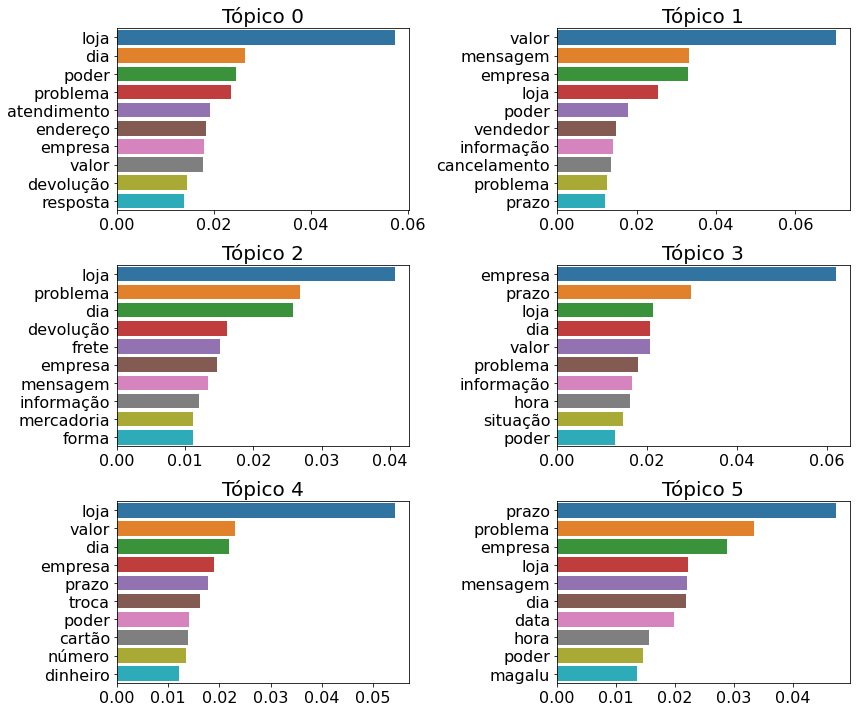

In [263]:
plot_topics_terms(lda_model_cluster_0, 'cluster_0_topics_terms_plot.png',0, 9)

#### **Cluster 1 topics visualization**

In [246]:
tokens = [
      [word for word in document.lower().split()]
      for document in cluster_1.texts
]
# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens] 

dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.70)

corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model_cluster_1 = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=20,
                           random_state=100,
                           passes=10,
                           iterations=100)

save_lda_vis('cluster_1', lda_model_cluster_1, lda_model_cluster_1.num_topics, corpus, dictionary)

# save topic terms
topics_terms = get_topics(lda_model_cluster_1, lda_model_cluster_1.num_topics)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_cluster_1.csv'), index=False)

vis = gs.prepare(lda_model_cluster_1, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


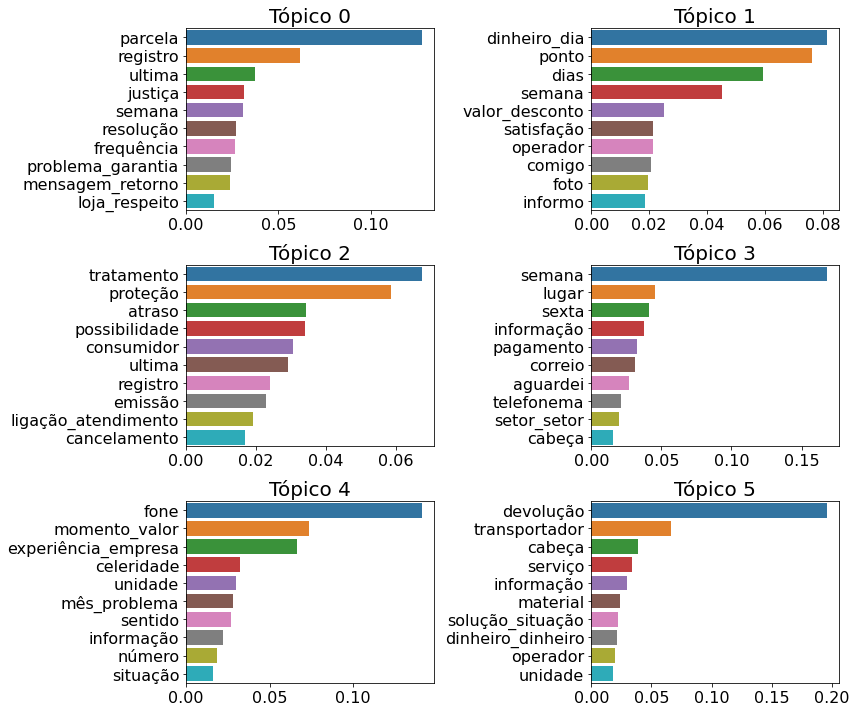

In [264]:
plot_topics_terms(lda_model_cluster_1,  'cluster_1_topics_terms_plot.png', 0, 9)

!rm -rf /root/.ssh/